In [1]:
from skimage.measure import find_contours
from skimage.feature import corner_harris, corner_peaks, canny 
from skimage.draw import polygon, circle_perimeter, line, disk
from skimage.filters.thresholding import threshold_otsu, threshold_local
from skimage.filters._median import median
from skimage.morphology.binary import binary_dilation, binary_erosion , binary_closing, binary_opening
from skimage.morphology import skeletonize
from skimage.transform.hough_transform import hough_circle, hough_circle_peaks, hough_line, hough_line_peaks
from skimage.color import rgb2gray
import skimage.io as io
import numpy as np
import cv2
import matplotlib.pyplot as plt




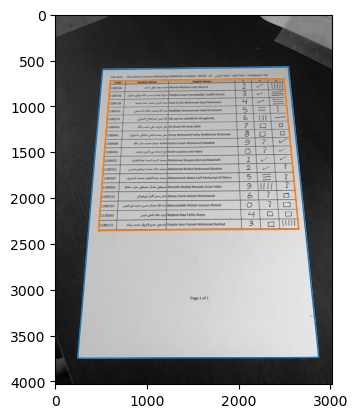

In [3]:
def Get_Corners(contour) -> np.ndarray:
    '''This function takes a contour as input and returns the corners of the mask, sorted in the order of top left, top right, bottom left, bottom right'''

    Top_Left = sorted(contour, key= lambda x: x[0]+x[1])[0]
    Top_Right = sorted(contour, key= lambda x: x[0]-x[1])[-1]
    Bottom_Left = sorted(contour, key= lambda x: x[0]-x[1])[0]
    Bottom_Right = sorted(contour, key= lambda x: x[0]+x[1])[-1]

    Corners=np.array([Top_Left,Top_Right,Bottom_Left,Bottom_Right])
    
    return Corners

def Get_Contour_Area(Contour):
    '''This function takes a contour as input and returns the area of the contour'''
    
    
    #Extract the corners of the current contour in the loop
    Top_Left = sorted(Contour, key= lambda x: x[0]+x[1])[0]
    Top_Right = sorted(Contour, key= lambda x: x[0]-x[1])[-1]
    Bottom_Left = sorted(Contour, key= lambda x: x[0]-x[1])[0]
    Bottom_Right = sorted(Contour, key= lambda x: x[0]+x[1])[-1]

    # Contour area is the product of the length and width of the contour
    Length = np.sqrt((Top_Left[0]-Top_Right[0])**2 + (Top_Left[1]-Top_Right[1])**2)
    Width = np.sqrt((Top_Left[0]-Bottom_Left[0])**2 + (Top_Left[1]-Bottom_Left[1])**2)
    
    
    Contour_Area = Length*Width
    
    return Contour_Area
 
# Load the image
i=6
# sample_image_rgb = io.imread('grade sheet/gradesheet/310931d4-cd80-49f7-88b4-0862acc06097.jpg')
# sample_image_rgb = io.imread('grade sheet\gradesheet\c0747b4e-a551-4532-b97a-2155d4696cd6.jpg')
# sample_image_rgb = io.imread('grade sheet\gradesheet/bff4906c-c00c-43e6-8660-d5b8350fcddd.jpg')
# sample_image_rgb = io.imread('grade sheet/gradesheet/IMG_6241.jpg')
sample_image_rgb = io.imread(f'grade sheet/{i}.jpg')

flag = False

sample_image_gray = rgb2gray(sample_image_rgb)
thresh = threshold_local(sample_image_gray, block_size=101,offset=0.1, method='gaussian')
sample_image_gray = sample_image_gray > thresh
# Find the contours
threshold_rel= ((sample_image_gray.max()+sample_image_gray.min())/2)*1.25

while True:
      Contours=find_contours(sample_image_gray, threshold_rel)
      # Sort the contours by area
      Contours = sorted(Contours, key=Get_Contour_Area, reverse=True)
      Paper_Contour= Contours[0] # The largest contour is the paper contour, the second largest contour is the bubble contour
      Inner_Contour= Contours[1]
      Ratio=Get_Contour_Area(Paper_Contour)/Get_Contour_Area(Inner_Contour)
      if Ratio < 1.2 or Ratio> 8:
                  sample_image_gray  = rgb2gray(sample_image_rgb)
                  flag= True
                  threshold_rel*=0.9
      else:     
            break


# Display the image and plot the largest 2 contours found
fig, ax = plt.subplots()
ax.imshow(sample_image_gray, cmap=plt.cm.gray)

for i in range(2):
      ax.plot(Contours[i][:, 1], Contours[i][:, 0], linewidth=1)

ax.axis('image')
plt.show()



In [4]:
Inner_Contour = np.flip(Inner_Contour, axis=1) # Flip the contour to match the image coordinates
# Extract the corners of the paper contour
Top_Left = sorted(Inner_Contour, key= lambda x: x[0]+x[1])[0]
Top_Right = sorted(Inner_Contour, key= lambda x: x[0]-x[1])[-1]
Bottom_Left = sorted(Inner_Contour, key= lambda x: x[0]-x[1])[0]
Bottom_Right = sorted(Inner_Contour, key= lambda x: x[0]+x[1])[-1]

Corners=np.array([Top_Left,Top_Right,Bottom_Left,Bottom_Right])


<function matplotlib.pyplot.show(close=None, block=None)>

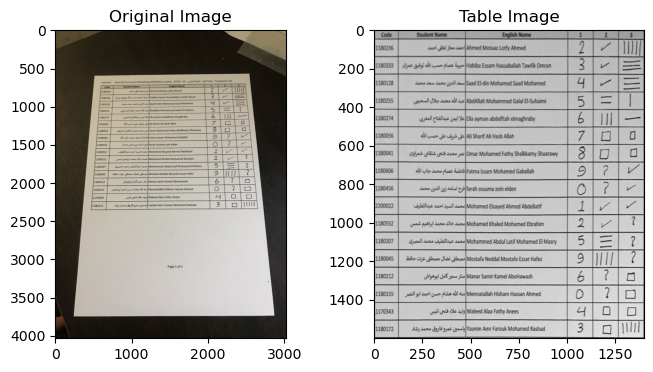

In [5]:
# Using the 4 corners of the contour, warp the image to a rectangle
size_multiplier = 5
width,height = 280*size_multiplier, 320*size_multiplier # The width and height of the final image

img= (255*sample_image_gray).astype(np.uint8)


pts1 = np.float32([Corners[0], Corners[1], Corners[2], Corners[3]]) # The 4 corners of the contour
pts2= np.float32([[0,0],[width,0],[0,height],[width,height]]) # The corners of the final image
matrix = cv2.getPerspectiveTransform(pts1,pts2) # The transformation matrix
result = cv2.warpPerspective(img,matrix,(width,height)) # The warped image
io.imsave(f'result{i}.jpg', result)

fig, (ax,ax1) = plt.subplots(ncols=2 , figsize=(8, 4))
ax.imshow(sample_image_rgb, cmap=plt.cm.gray)
ax.set_title('Original Image')
ax1.imshow(result, cmap=plt.cm.gray)
ax1.set_title('Table Image')
plt.show


In [6]:
binary = result
if flag is True: # Threshold if not already thresholded.
    thresh = threshold_local(result, block_size=101,offset=15, method='gaussian', param=20)
    binary = result > thresh
io.imsave("binary_local.jpg", binary)

C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_176\1050814734.py:5: UserWarning: binary_local.jpg is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave("binary_local.jpg", binary)


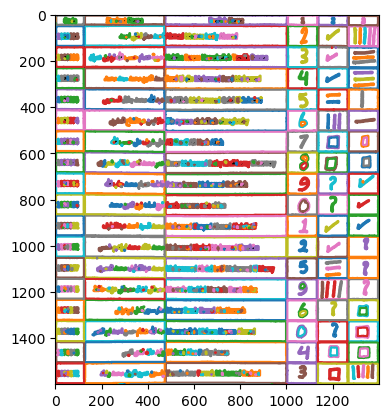

In [7]:
# If we try to find the contours initially, we get a lot of irrelevent contours.
Cells= find_contours(binary)
fig,ax = plt.subplots()
ax.imshow(binary,cmap=plt.cm.gray)

Cells=sorted(Cells, key=Get_Contour_Area, reverse=True)
for cell in Cells:
    ax.plot(cell[:,1],cell[:,0])
    

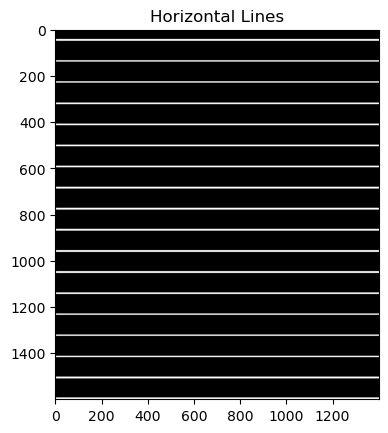

In [8]:
# Instead, we shall reconstruct the table by finding the horizontal and vertical lines first.
# Detect the horizontal lines through repeated binary erosion dilation
length = binary.shape[1]//10
horizontal_kernel = np.ones((1,length), np.uint8)
Horizontal_Image= ~binary.copy()

# Erosion yields only the horizontal lines and removes the noise.
for i in range(2): Horizontal_Image = binary_erosion(Horizontal_Image, horizontal_kernel)

# The resulting lines are choppy, so we dilate them to get the full lines.
for i in range(30): Horizontal_Image = binary_dilation(Horizontal_Image, horizontal_kernel)

# Some lines are detected twice, so we remove them. and add a line in between the two lines.

Min_Distance= 30
Y1=0
Y2=0


# # Remove double detected lines

# for i in range(Horizontal_Image.shape[0]): # In range of the height of the image
#     if Horizontal_Image[i,0]==1 and Y1==0: # If a line is detected and Y1 is not set
#         Y1=i # Set Y1 to the current line
#         continue
    
#     if Horizontal_Image[i,0]==1 and Y1!=0: # If a line is detected and Y1 is set
#         Y2=i # Set Y2 to the current line
#         z=Y2 
        
#         if Y2-Y1 < Min_Distance: # If the distance between the two lines is less than the minimum distance
#             while Horizontal_Image[z,0]==1: # While the next row is a line
#                 z+=1 # Increment z
#                 if z==Horizontal_Image.shape[0]: break # If z is out of bounds, break
                
#             Horizontal_Image[Y1:Y1+Min_Distance,:]=0 # Remove the first line
#             Horizontal_Image[(Y1+z)//2,:]=1 # Add a line in between the two lines
#         Y1=Y2
#         Y2= 0

    

# # Remove the edge borders
# Horizontal_Image[:40,:]=0
# Horizontal_Image[-40:,:]=0
# Horizontal_Image[:2,:]=1
# Horizontal_Image[-2:,:]=1

fig,ax = plt.subplots()
ax.imshow(Horizontal_Image,cmap=plt.cm.gray)
ax.set_title("Horizontal Lines")
plt.show()

In [9]:
# Count the horizontal lines --> rows = Lines+1
# Remove the edges of the image to prevent false positives

Row_Num=len(find_contours(Horizontal_Image))//2

print(f'There are {Row_Num} rows')


There are 18 rows


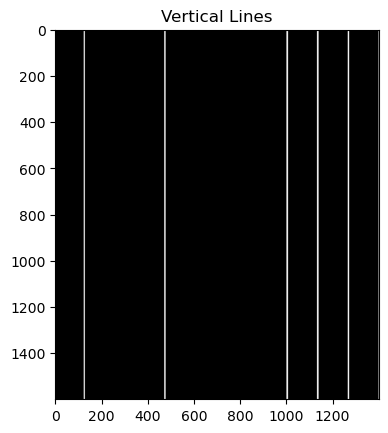

In [10]:
# Detect the vertical lines through repeated binary erosion and dilation
vertical_kernel = np.ones((length,1), np.uint8)
Vertical_Image= ~binary.copy()

# Erosion yields only the vertical lines and removes the cell contents.
for i in range(3): Vertical_Image = binary_erosion(Vertical_Image, vertical_kernel)
# Dilation extends the lines to get the full lines.
for i in range(30): Vertical_Image = binary_dilation(Vertical_Image, vertical_kernel)

# Sometimes the lines representing the borders of the table are not detected. Other times they are detected.
# To solve this we remove the lines that are too close to the borders of the image.
# Remove the edge borders
Vertical_Image[:,0:40]=0
Vertical_Image[:,-40:]=0

# Then we consider the borders of the image as the borders of the table.
Vertical_Image[:,0:2]=1
Vertical_Image[:,-2:]=1


fig,ax = plt.subplots()
ax.imshow(Vertical_Image,cmap=plt.cm.gray)
ax.set_title("Vertical Lines")
plt.show()


In [11]:
# Count the vertical lines --> Columns = Lines-1
Col_Num=len(find_contours(Vertical_Image))//2
Coll=len(find_contours(Vertical_Image))//2
print(f'There are {Col_Num} columns')


There are 6 columns


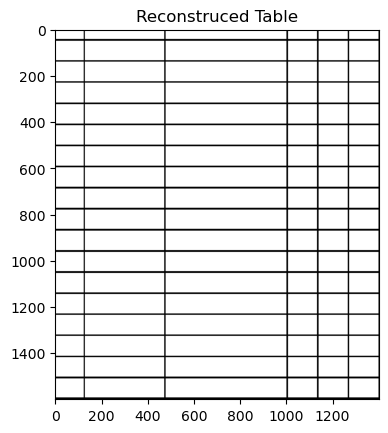

In [12]:
Reconstructed_Image = Horizontal_Image | Vertical_Image
Reconstructed_Image = ~Reconstructed_Image


fig,ax = plt.subplots()
ax.imshow(Reconstructed_Image,cmap=plt.cm.gray)
ax.set_title("Reconstruced Table")
plt.show()


Number of cells found: 108
Number of cells expected: 108


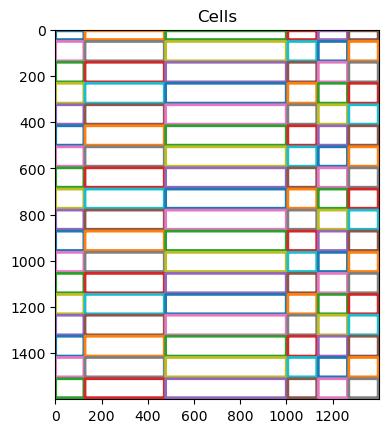

In [13]:
# Find the contours of the reconstructed image
Contours = find_contours(Reconstructed_Image)
Cells= []
# Flip the contours to match the image coordinates since the contours are in (y,x) format
Contours = [np.flip(contour, axis=1) for contour in Contours]

# Filter out the contours that are not cells by their height (Small contours found at the edges of the image between the table and the paper)
for cell in Contours:
    Top_Left, _, Bottom_Left, _ = Get_Corners(cell)
    cell_height = abs(Top_Left[1]-Bottom_Left[1])
    if cell_height < 30:
        continue
    else:
        Cells.append(cell)

Cells = [np.flip(cell, axis=1) for cell in Cells]


print(f"Number of cells found: {len(Cells)}")
print(f"Number of cells expected: {Row_Num*Col_Num}")

fig, ax = plt.subplots()
ax.imshow(Reconstructed_Image, cmap=plt.cm.gray)
ax.set_title('Cells')
for contour in Cells:
    ax.plot(contour[:,1], contour[:,0], linewidth=2)

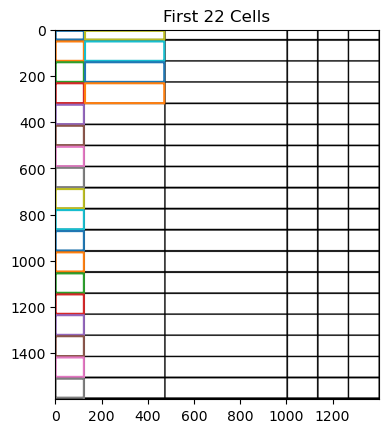

In [14]:
# Now we sort the contours from top to bottom
Cells = sorted(Cells, key= lambda x: x[0][1])

# Plot the contours
k= Row_Num+4
fig, ax = plt.subplots()
ax.imshow(Reconstructed_Image, cmap=plt.cm.gray)
ax.set_title(f'First {k} Cells')
for contour in Cells[:k]:
    ax.plot(contour[:,1],contour[:,0])


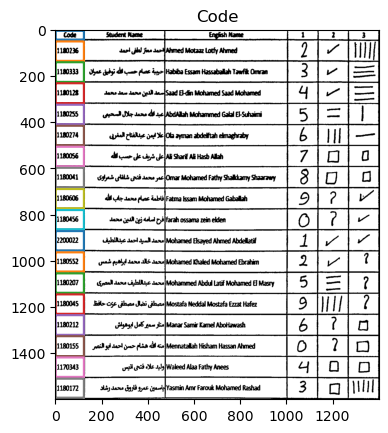

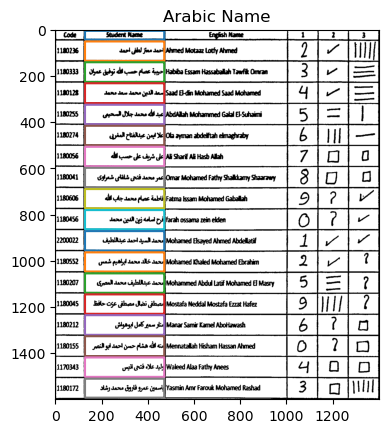

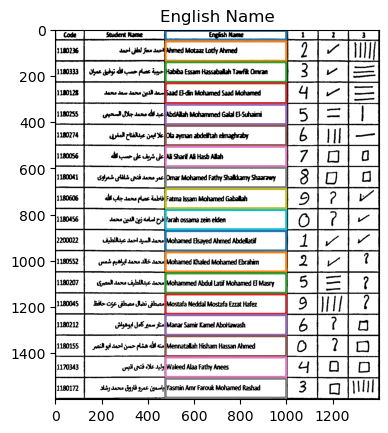

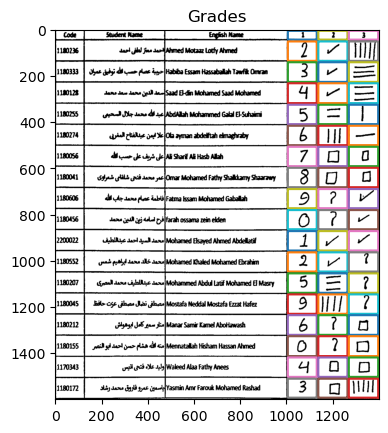

In [15]:
# Student Code Contours
Student_Codes = Cells[:Row_Num]
Student_Names_Arabic = Cells[Row_Num:2*Row_Num]
Student_Names_English = Cells[2*Row_Num:3*Row_Num]
Grades=np.zeros([Col_Num-3, Row_Num],dtype=np.ndarray)

for Col in range(Col_Num-3):
    for Row in range(Row_Num):
        Grades[Col][Row]= Cells[(Col_Num-3+Col)*Row_Num+Row]

#==============================================================================        
# Plots
#==============================================================================
        
fig,ax1= plt.subplots()
ax1.imshow(binary,cmap=plt.cm.gray)
ax1.set_title("Code")
for contour in Student_Codes:
    ax1.plot(contour[:,1],contour[:,0])

fig,ax1= plt.subplots()
ax1.imshow(binary,cmap=plt.cm.gray)
ax1.set_title("Arabic Name")
for contour in Student_Names_Arabic:
    ax1.plot(contour[:,1],contour[:,0])

fig,ax1= plt.subplots()
ax1.imshow(binary,cmap=plt.cm.gray)
ax1.set_title("English Name")
for contour in Student_Names_English:
    ax1.plot(contour[:,1],contour[:,0])

fig,ax1= plt.subplots()
ax1.imshow(binary,cmap=plt.cm.gray)
ax1.set_title("Grades")
for column in Grades:
    for contour in column:
        ax1.plot(contour[:,1],contour[:,0])


c:\Users\Karim Negm\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_176\2765413750.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  g=stats.mode(labely) # most voted neighbor
c:\Users\Karim Negm\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typica

0 18
[1.] [1.]
[1.] [1.]
[1.] [1.]


C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_176\2765413750.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  g=stats.mode(labely) # most voted neighbor
c:\Users\Karim Negm\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or

[1.] [1.]
[1.] [1.]
[1.] [1.]
[1.] [1.]


C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_176\2765413750.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  g=stats.mode(labely) # most voted neighbor
c:\Users\Karim Negm\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or

[1.] [1.]
[1.] [1.]
[1.] [1.]
[1.] [1.]


C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_176\2765413750.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  g=stats.mode(labely) # most voted neighbor
c:\Users\Karim Negm\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or

[1.] [1.]
[1.] [1.]
[1.] [1.]
[1.] [1.]


C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_176\2765413750.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  g=stats.mode(labely) # most voted neighbor
c:\Users\Karim Negm\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or

[1.] [1.]
[1.] [1.]
[1.] [1.]
[1.] [1.]


C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_176\2765413750.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  g=stats.mode(labely) # most voted neighbor
c:\Users\Karim Negm\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or

[1.] [1.]
[1.] [1.]
[1.] [1.]
[1.] [1.]
[1.] [1.]


C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_176\2765413750.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  g=stats.mode(labely) # most voted neighbor
c:\Users\Karim Negm\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or

[1.] [1.]
[1.] [1.]


C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_176\2765413750.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  g=stats.mode(labely) # most voted neighbor
c:\Users\Karim Negm\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or

[1.] [1.]
[1.] [1.]
[1.] [1.]
[1.] [1.]
[1.] [1.]
[1.] [1.]
[1.] [1.]
[1.] [1.]


C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_176\2765413750.py:62: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  g=stats.mode(labely) # most voted neighbor
c:\Users\Karim Negm\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or

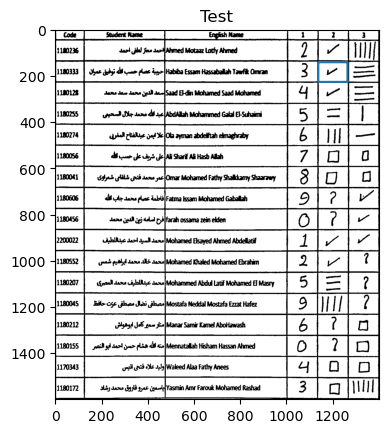

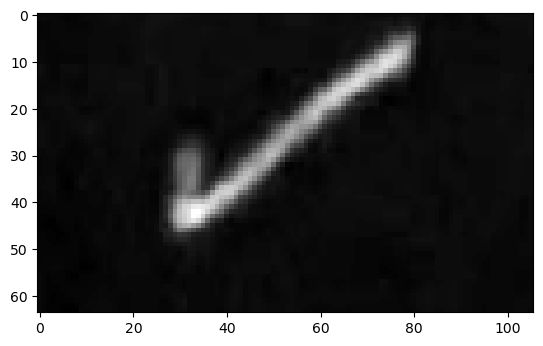

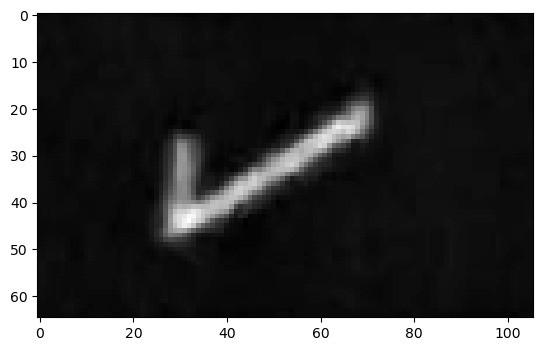

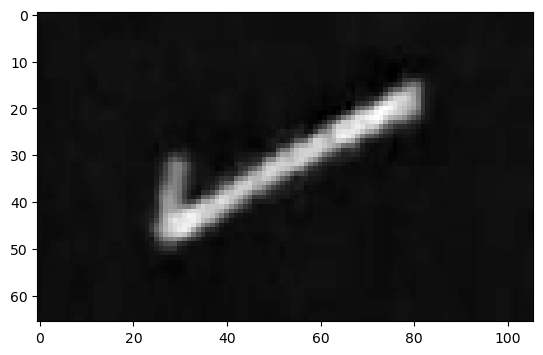

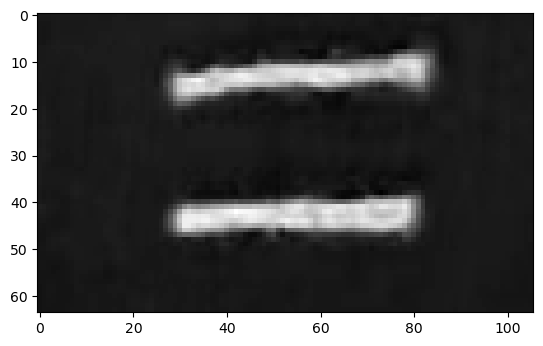

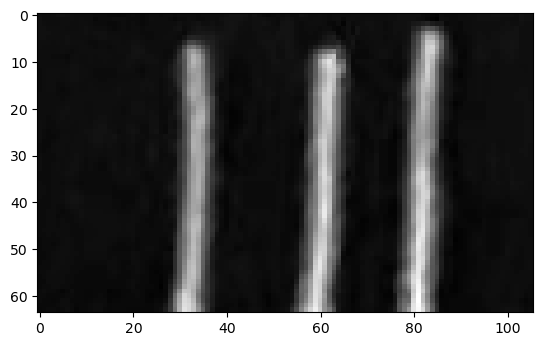

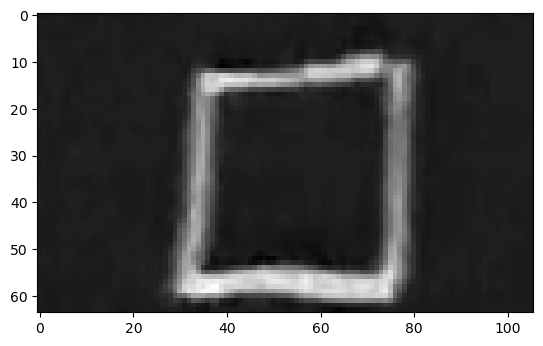

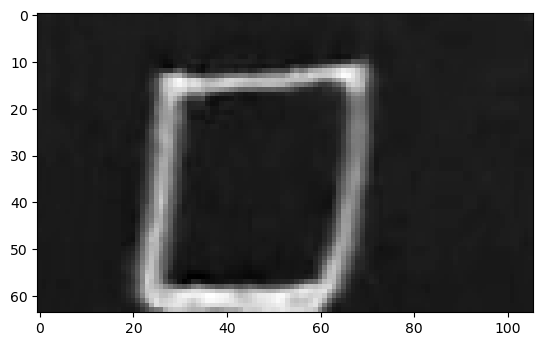

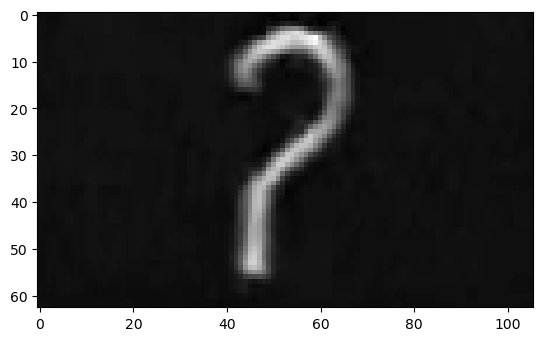

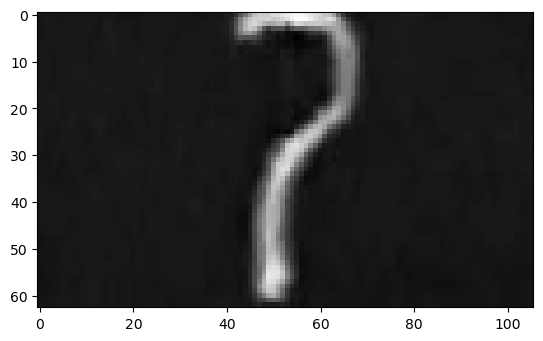

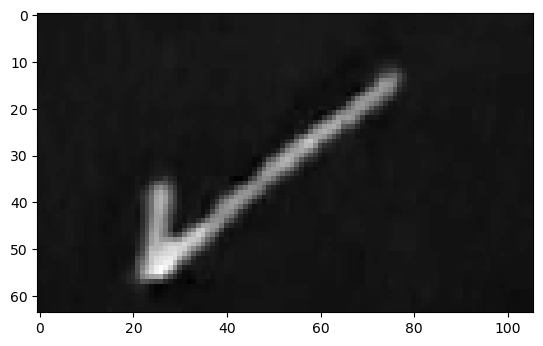

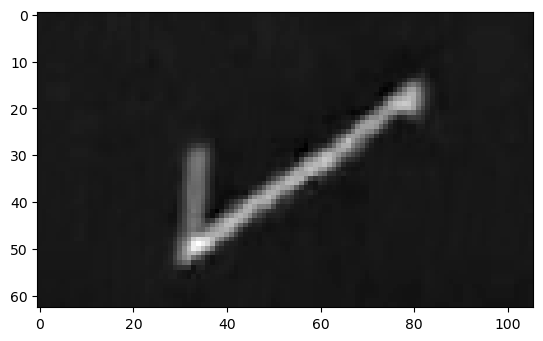

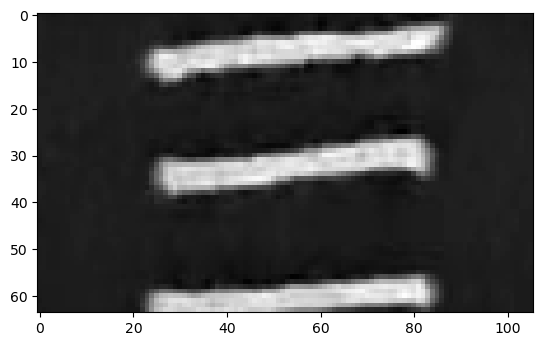

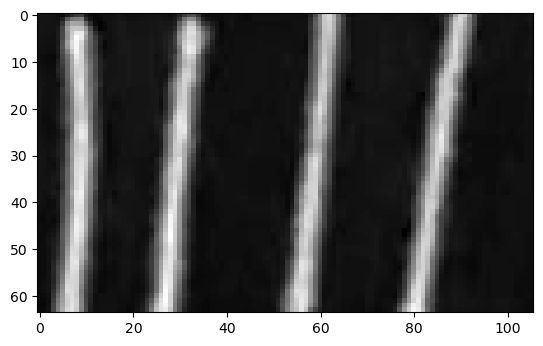

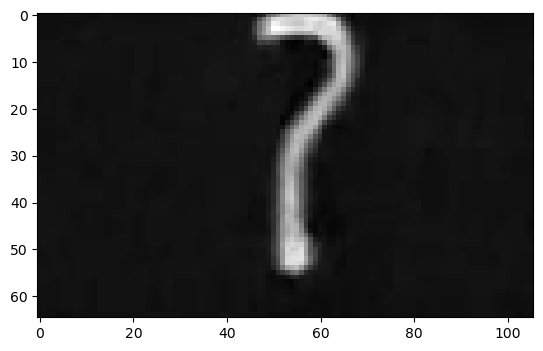

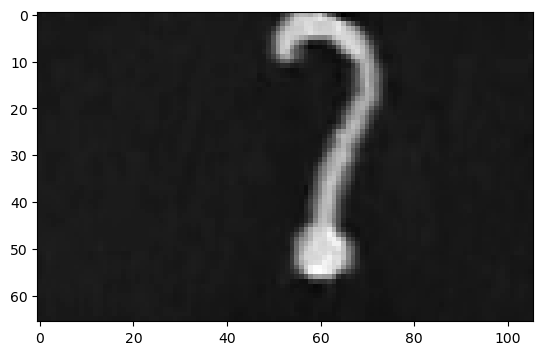

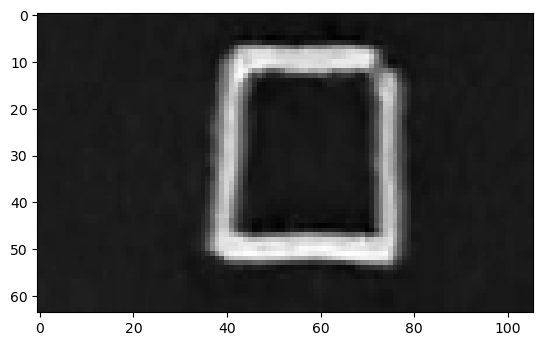

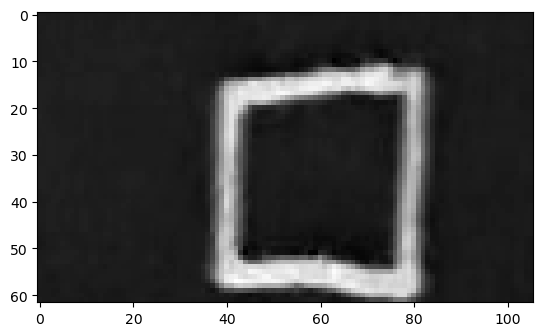

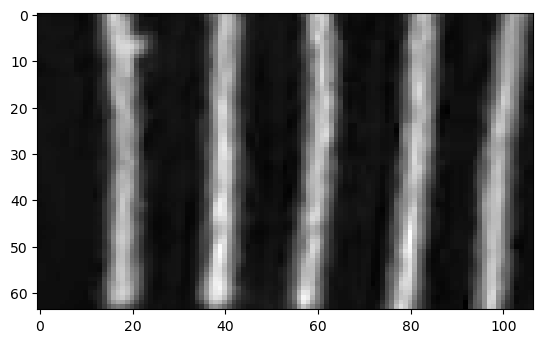

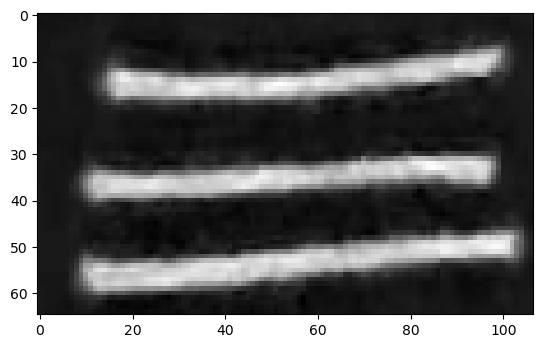

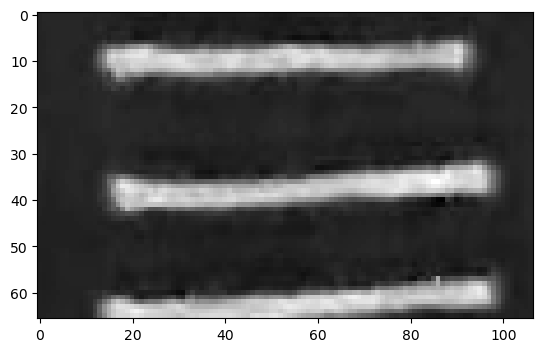

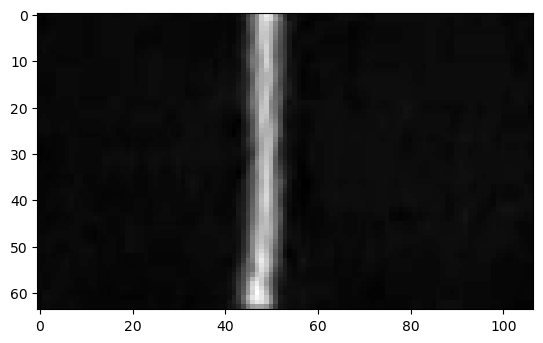

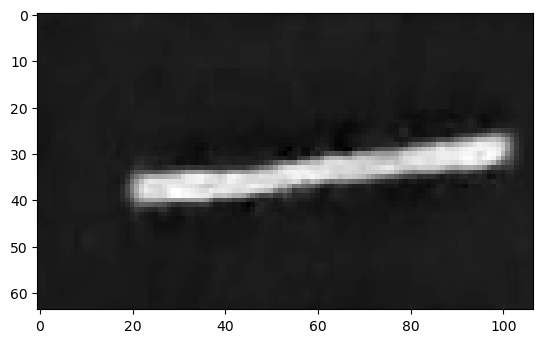

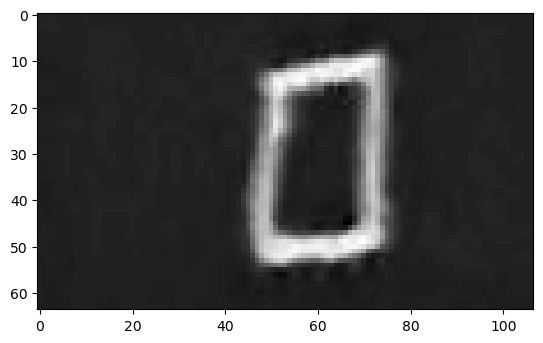

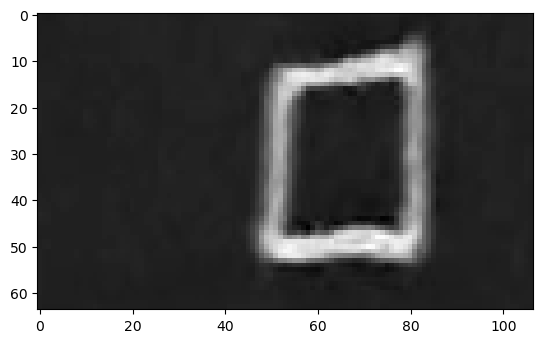

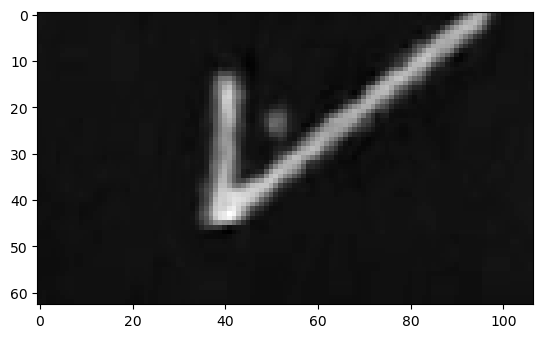

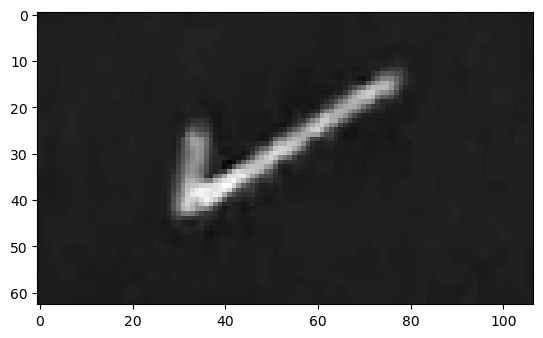

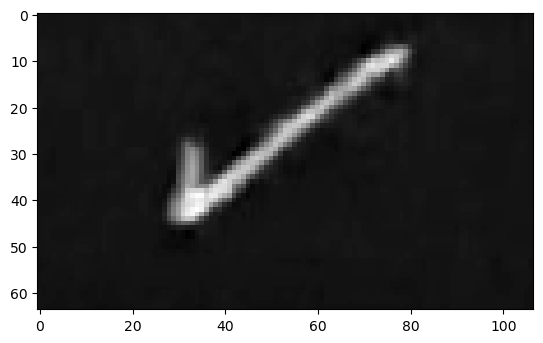

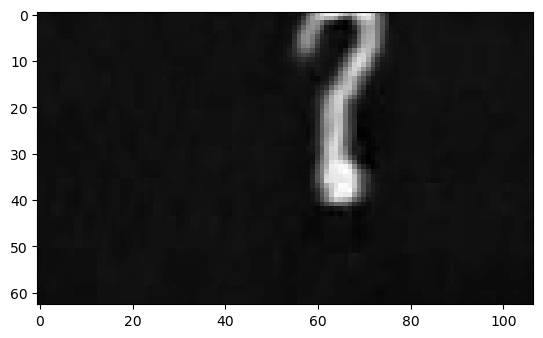

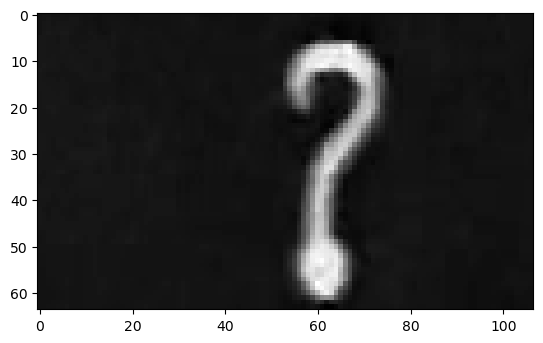

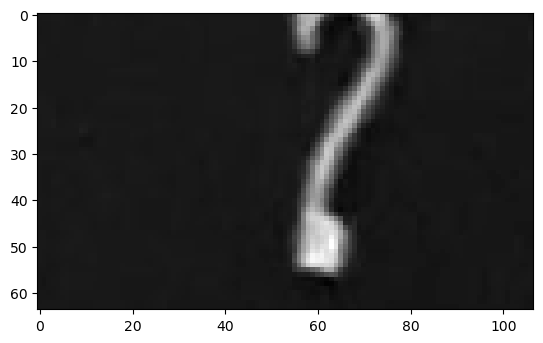

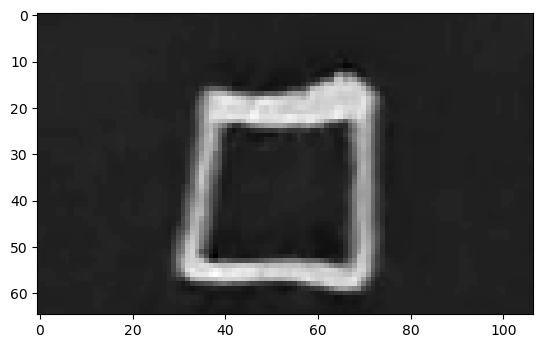

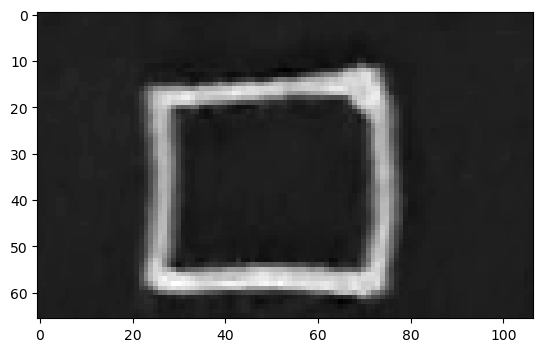

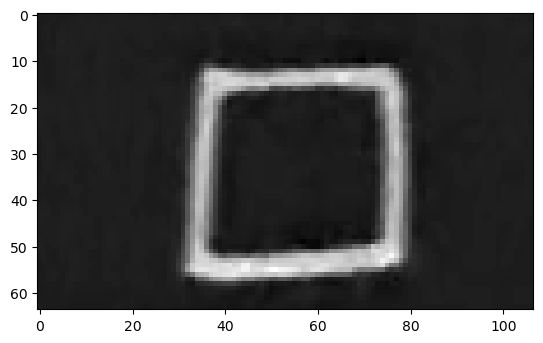

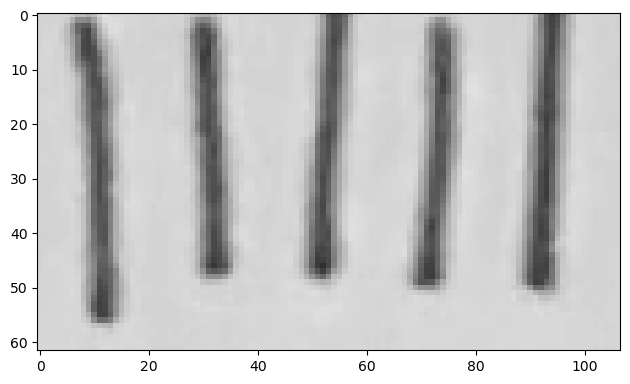

In [31]:
from collections import Counter
from scipy import stats
from skimage.measure import find_contours
from skimage.feature import corner_harris, corner_peaks, canny
from skimage.color import rgb2gray
from skimage.filters import threshold_local, median
import skimage.io as io
import numpy as np
import numpy as np
from PIL import Image
from commonfunctions import *
import cv2 as cv
from numpy import asarray, sqrt
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from skimage.io import imread
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import os



def load_images(dir_name, dimension=(20, 20)):
    l = os.listdir(dir_name)
    lsorted = sorted(l, key=lambda x: int(os.path.splitext(x)[0]))
    train_img = []
    for file in lsorted:
            img = imread("knn_sq\\"+file)
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            img_pred = cv.resize(img, (20, 20), interpolation=cv.INTER_AREA)
            img_pred = asarray(img_pred)
            img_pred = img_pred / 255
            train_img.append(img_pred)

    X = np.array(train_img)

    return X


def KNN(train, test, label):
        y= np.array(label.reshape(len(label)))
        distance = [] 
        data = []
        for i in train:
            dist = 0
            for j in range(20*20): 
               dist += abs(test[0][j]-i[j])
            dist = (dist)
            distance.append(dist)
            data.append(i)
        distance = np.array(distance)
        data = np.array(data)
        index_dist = distance.argsort()
        data = data[index_dist]
        y=y[index_dist]
        neighbors = data[:3]
        labely=y[:4] #4 neighbors 
        g=stats.mode(labely) # most voted neighbor 
        ans=g[0]
        return ans


X = []
X = load_images("knn_sq")
# zero for a check
#one for a square 
#two for question mark 
#three for empty cell 
y0 = np.zeros(10)
y1 = np.ones(10)
y2=np.full(10,2)
y3=np.full(10,3)
y4=np.full(14,0)
y = []
y = np.concatenate((y0,y1, y2, y3,y4), axis=0)
l=y
X = X.reshape(X.shape[0], -1)
model = KNeighborsClassifier(n_neighbors=3)
y = y.reshape(y.shape[0], -1)
model.fit(X,y)

fig,ax1= plt.subplots()
ax1.imshow(binary,cmap=plt.cm.gray)
ax1.set_title("Test")
row=2
col=1
ax1.plot(Grades[col,row][:,1],Grades[col,row][:,0])
print(Col_Num,Row_Num )
for j in range (1,3):
    for i in range (1,Row_Num):
        Corners = Get_Corners(Grades[j,i]).astype(int)
        Xmin = np.min(Corners,axis=0)[0]+10
        Xmax = np.max(Corners,axis=0)[0]-10
        Ymin = np.min(Corners,axis=0)[1]+10
        Ymax = np.max(Corners,axis=0)[1]-10
        Cropped_Image = result[Xmin:Xmax,Ymin:Ymax]
        img = ~Cropped_Image
        # img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        sd=cv.resize(img, (20, 20), interpolation=cv.INTER_AREA)
        img_pred = cv.resize(img, (20, 20), interpolation=cv.INTER_AREA)
        img_pred = asarray(img_pred)
        # img_pred = img_pred / 255
        img_pred = np.reshape(img_pred,(1,20*20))
        fig,ax= plt.subplots()
        ax.imshow(img,cmap=plt.cm.gray)
        

        myKnn=KNN(X, img_pred, y)
        predicted= model.predict(img_pred) 
        print(predicted, myKnn)
        # print(accuracy_score([0], pp))

     

# Crop the image

io.imshow(Cropped_Image)


There are 0 columns


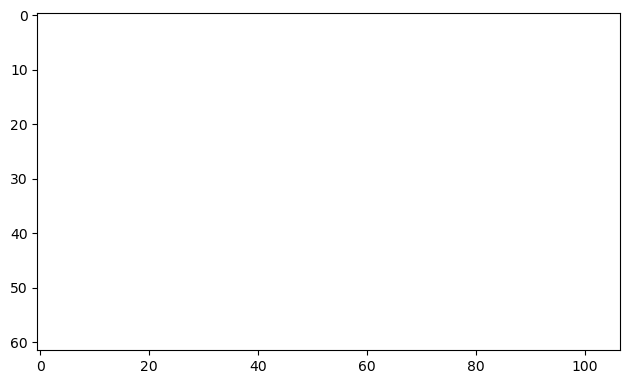

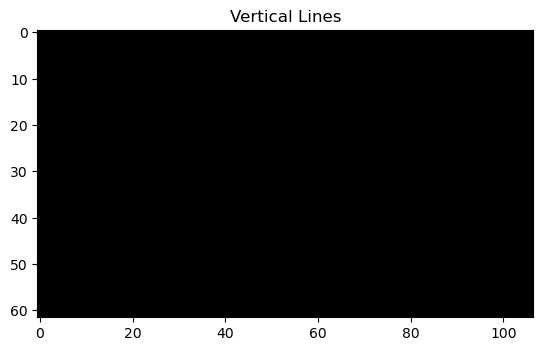

In [29]:
# Detect the vertical lines through repeated binary erosion and dilation
length = Cropped_Image.shape[1]//10
vertical_kernel = np.ones((length,1), np.uint8)
Vertical_Image= ~Cropped_Image.copy()

# Erosion yields only the vertical lines and removes the cell contents.
for i in range(3): Vertical_Image = binary_erosion(Vertical_Image, vertical_kernel)
# Dilation extends the lines to get the full lines.
for i in range(30): Vertical_Image = binary_dilation(Vertical_Image, vertical_kernel)

io.imshow(Vertical_Image)

# Count the vertical lines --> Columns = Lines-1
Col_Num=len(find_contours(Vertical_Image))//2
print(f'There are {Col_Num} columns')

# plot the contours
fig,ax1= plt.subplots()
ax1.imshow(Vertical_Image,cmap=plt.cm.gray)
ax1.set_title("Vertical Lines")
Contours = find_contours(Vertical_Image)
for contour in Contours:
    ax1.plot(contour[:,1],contour[:,0])



There are 0 horizontal lines


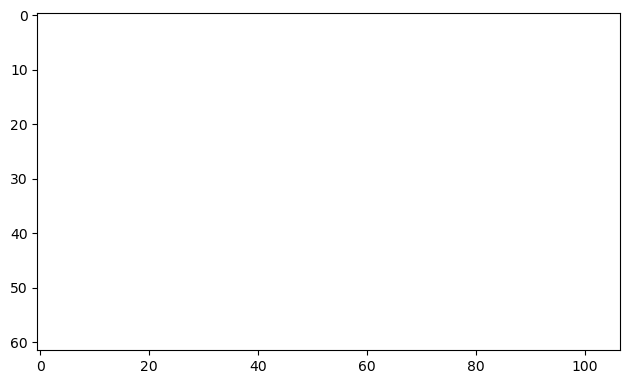

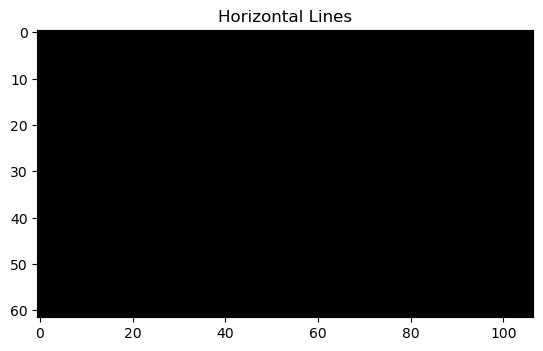

In [30]:
# Detect the vertical lines through repeated binary erosion and dilation
length = Cropped_Image.shape[1]//10
horizontal_kernel = np.ones((1,length), np.uint8)
Horizontal_Image= ~Cropped_Image.copy()

# Erosion yields only the vertical lines and removes the cell contents.
for i in range(3): Horizontal_Image = binary_erosion(Horizontal_Image, horizontal_kernel)
# Dilation extends the lines to get the full lines.
for i in range(30): Horizontal_Image = binary_dilation(Horizontal_Image, horizontal_kernel)

io.imshow(Horizontal_Image)
Contours = find_contours(Horizontal_Image)
HLines=len(Contours)//2
print(f'There are {HLines} horizontal lines')

# plot the contours
fig,ax1= plt.subplots()
ax1.imshow(Horizontal_Image,cmap=plt.cm.gray)
ax1.set_title("Horizontal Lines")

for contour in Contours:
    ax1.plot(contour[:,1],contour[:,0])


